In [1]:
import os
import datetime
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# general-purpose libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

# Scikit-Learn
import sklearn
from sklearn import linear_model
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import tree

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve,roc_auc_score,precision_score,recall_score,auc, accuracy_score, f1_score, classification_report


# Constructs a new estimator with the same parameters.
# Clone does a deep copy of the model in an estimator 
# without actually copying attached data. It yields a 
# new estimator with the same parameters that has not 
# been fit on any data.
from sklearn import clone 

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,BaggingClassifier)
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


# libraries needed to plot decision trees
import io
from scipy import misc
from scipy.stats import randint
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', 500)

In [10]:
plt.style.use('fivethirtyeight')

In [2]:
def build_df():
    """
    Once the files have been unzipped, let's build some dataframes from the three types of data we have:
    IE phone calls, contacts, and text messages

    :return:
    Three pandas.DataFrames [calls, contacts, sms]
    """

    # Set our top-level file path to find all the data
    origin_root = "../data/user_logs/"

    # Create multiple lists so we can concat later
    call_list = list()
    contact_list = list()
    sms_list = list()

    # TODO: research about writing on the fly when unzipping the files
    for root, dirs, files in os.walk(origin_root):
        for file in files:
            if file.endswith("collated_call_log.txt"):
                user_and_device = str(root[18:])
                user_id, device_id = user_and_device.split("/")[
                    0
                ], user_and_device.split(
                    "/"
                )[
                    1
                ]
                tmp_txt = os.path.join(root, file)
                temp_df = pd.read_json(tmp_txt)
                temp_df["user_id"] = user_id
                temp_df["device_id"] = device_id
                call_list.append(temp_df)
            elif file.endswith("collated_contact_list.txt"):
                user_and_device = str(root[18:])
                user_id, device_id = user_and_device.split("/")[
                    0
                ], user_and_device.split(
                    "/"
                )[
                    1
                ]
                tmp_txt = os.path.join(root, file)
                temp_df = pd.read_json(tmp_txt)
                temp_df["user_id"] = user_id
                temp_df["device_id"] = device_id
                contact_list.append(temp_df)
            elif file.endswith("collated_sms_log.txt"):
                user_and_device = str(root[18:])
                user_id, device_id = user_and_device.split("/")[
                    0
                ], user_and_device.split(
                    "/"
                )[
                    1
                ]
                tmp_txt = os.path.join(root, file)
                temp_df = pd.read_json(tmp_txt)
                temp_df["user_id"] = user_id
                temp_df["device_id"] = device_id
                sms_list.append(temp_df)

    # Combine the respective data in their own groupings
    call_df = pd.concat(call_list, axis=0)
    contact_df = pd.concat(contact_list, axis=0)
    sms_df = pd.concat(sms_list, axis=0)

    return call_df, contact_df, sms_df

call_df, contact_df, sms_df = build_df()

In [53]:
loan_df = pd.read_csv("../data/user_logs/user_status.csv", parse_dates=['disbursement_date'])
loan_df['user_id'] = "user-" + loan_df['user_id'].apply(str)
dummy_loans = pd.get_dummies(loan_df['status'])
loan_df = pd.concat([loan_df, dummy_loans], axis=1)

# Create High level features

In [3]:
dates_loans = loan_df.copy()
dates_loans = dates_loans.set_index('disbursement_date').groupby(pd.Grouper(freq='D')).sum().dropna()
dates_loans['total_loans'] = dates_loans['defaulted'] + dates_loans['repaid']
dates_loans['prop_default'] = dates_loans['defaulted'] / dates_loans['total_loans']

([<matplotlib.axis.YTick at 0x1205bb4a8>,
 <a list of 6 Text yticklabel objects>)

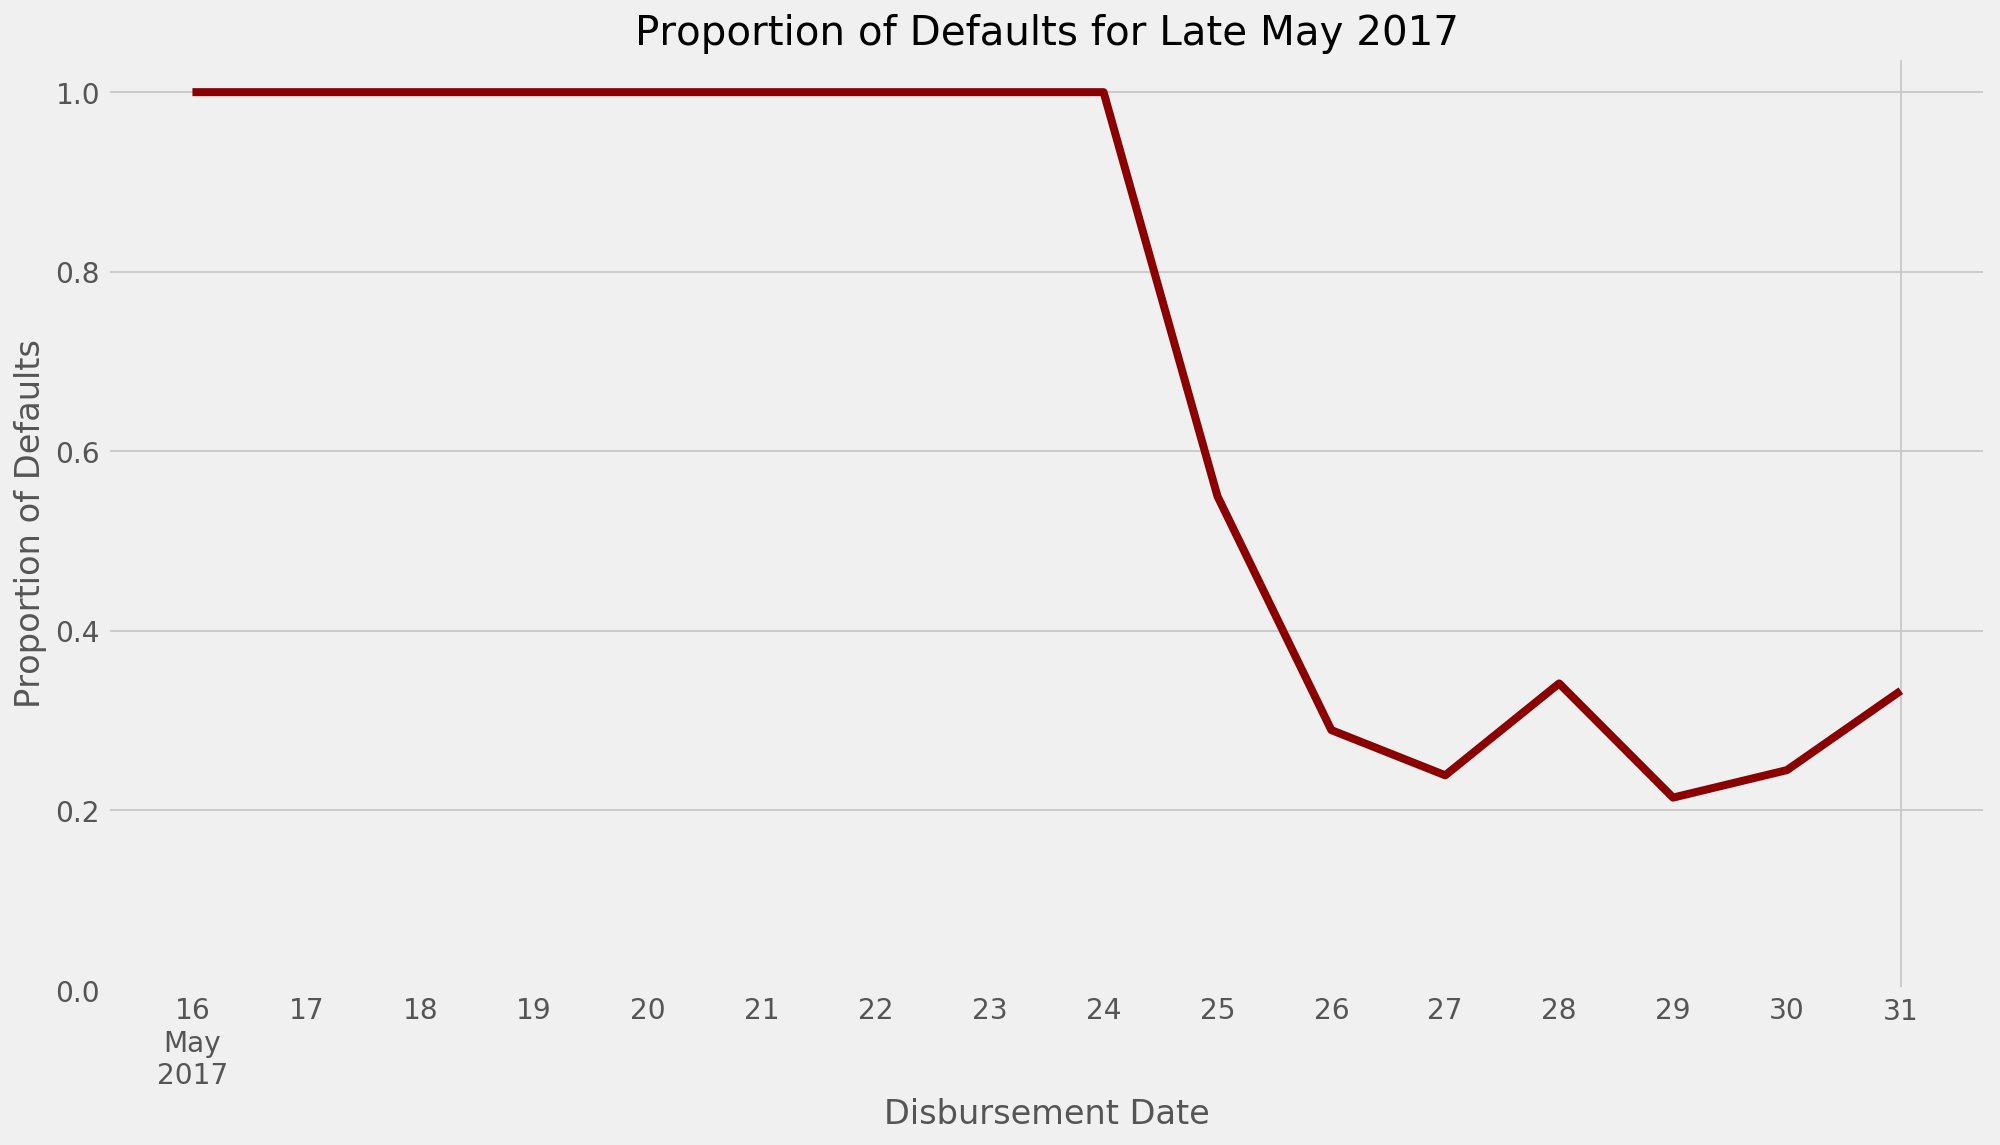

In [13]:
dates_loans.plot(x=dates_loans.index, y='prop_default', kind="line", legend=False, color='darkred', figsize=(15,8))
plt.ylabel("Proportion of Defaults")
plt.xlabel("Disbursement Date")
plt.title("Proportion of Defaults for Late May 2017")
plt.yticks(np.arange(0, 1.2, step=0.2))

In [54]:
# Time Variables
loan_df['day_of_month'] = loan_df.disbursement_date.dt.day

In [7]:
call_df['day_of_month'] = call_df.datetime.dt.day
call_df['weekday'] = call_df.datetime.dt.dayofweek
call_df['hour_of_day'] = call_df.datetime.dt.hour
call_df['day_of_year'] = call_df.datetime.dt.dayofyear
call_df['month_int'] = call_df.datetime.dt.month
call_df['only_date'] = call_df.datetime.dt.date

In [8]:
dates_calls = call_df.groupby('only_date').agg({'datetime': "count"})

Text(0.5,1,'Number of Unique Phone Calls by All Users')

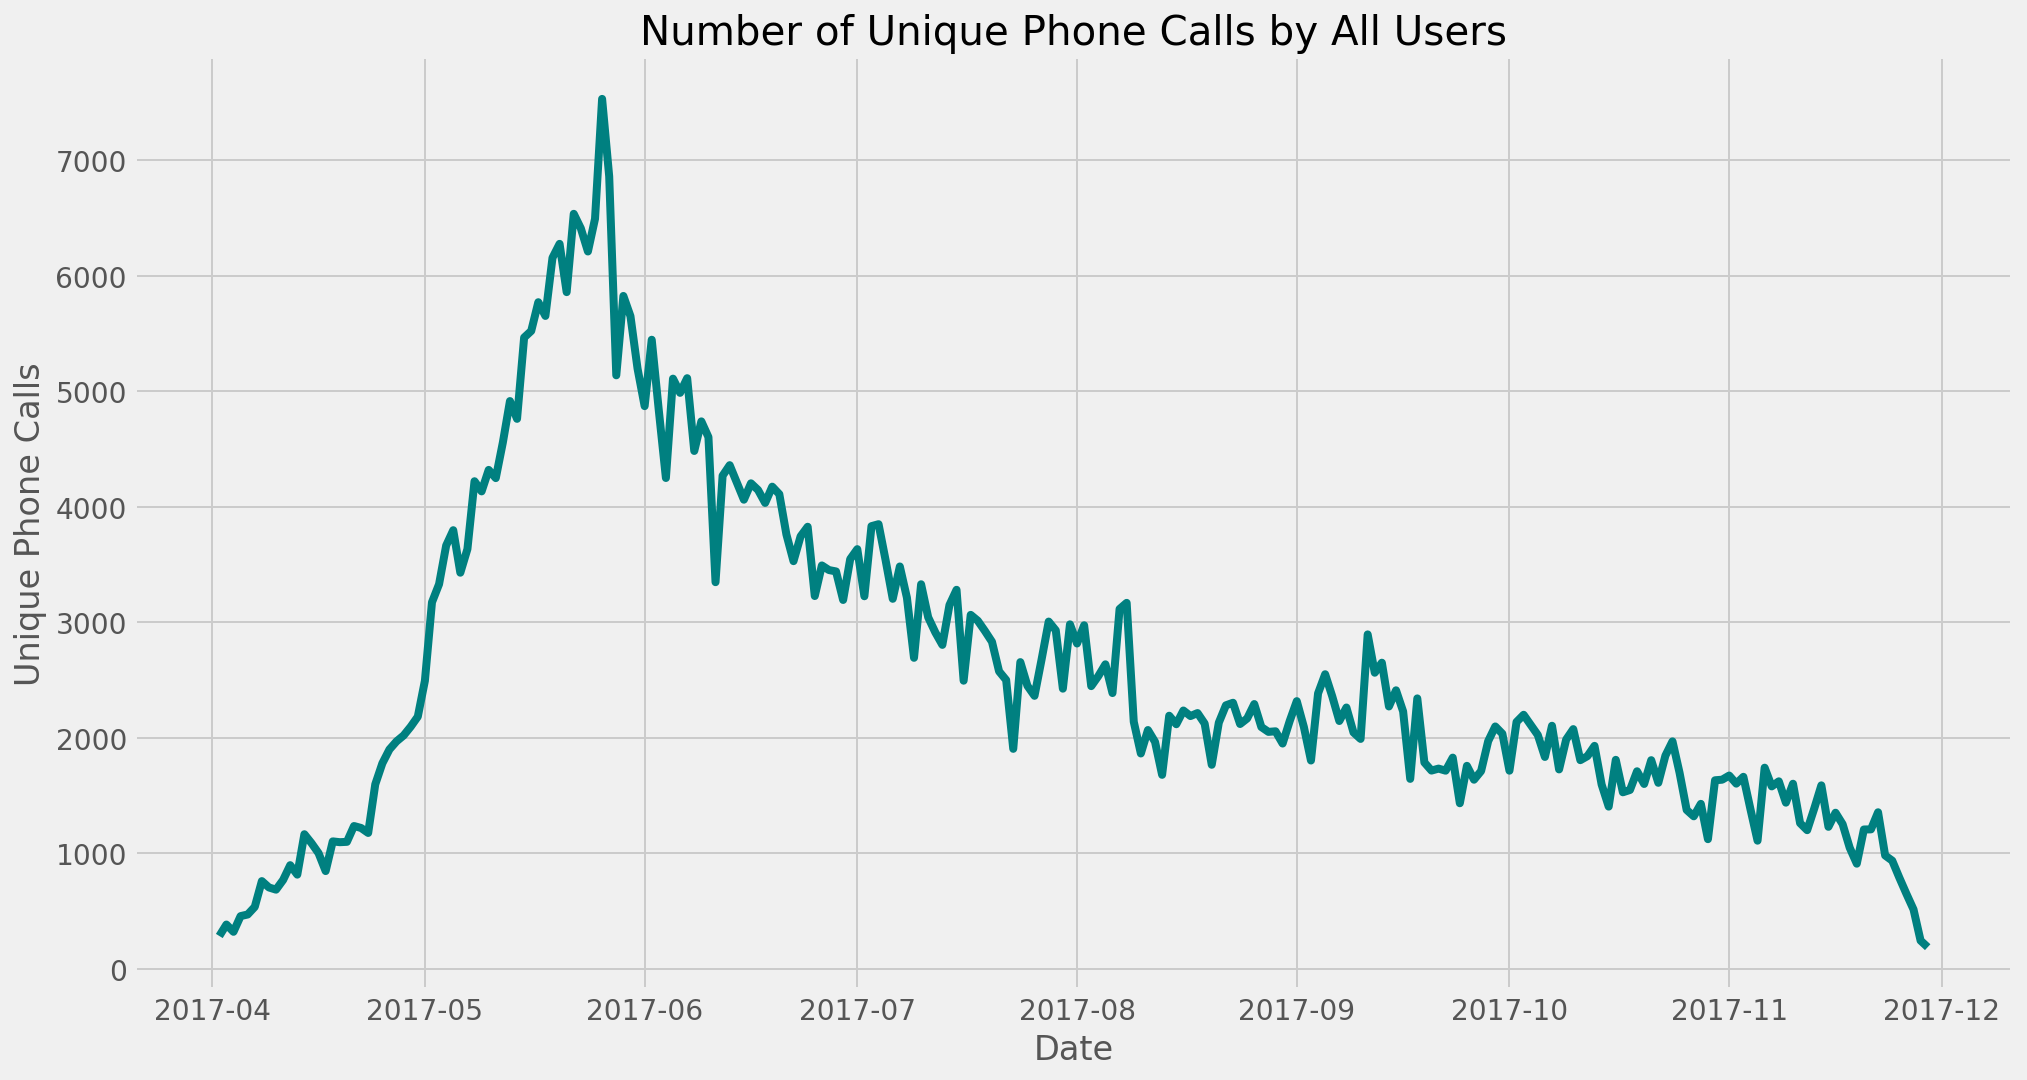

In [12]:
lower_split_date = datetime.date(int(2017),int(4),int(1))
upper_split_date = datetime.date(int(2018),int(3),int(1))

dates_calls[(dates_calls.index > lower_split_date) & (dates_calls.index < upper_split_date)].plot(x=dates_calls[(dates_calls.index > lower_split_date) & (dates_calls.index < upper_split_date)].index, y='datetime', legend=False, color='teal', figsize=(15,8))
plt.ylabel("Unique Phone Calls")
plt.xlabel("Date")
plt.title("Number of Unique Phone Calls by All Users")

In [15]:
sent_df = sms_df.loc[(sms_df['sms_type'] == 2.0), ['user_id', 'message_body']]
inbox_df = sms_df.loc[(sms_df['sms_type'] == 1.0), ['user_id', 'message_body']]

In [33]:
sent_df['word_count'] = sent_df['message_body'].apply(lambda x: len(str(x).split(" ")))
sent_df['char_count'] = sent_df['message_body'].str.len()

agg_sent_df = sent_df.groupby('user_id').agg({"word_count": [max, sum, "mean", "median", "std"], 
                                              "char_count": [max, sum, "mean", "median", "std"]})
agg_sent_df.columns = ["_sent_".join(x) for x in agg_sent_df.columns.ravel()]
agg_sent_df.reset_index(inplace=True)

In [34]:
inbox_df['word_count'] = inbox_df['message_body'].apply(lambda x: len(str(x).split(" ")))
inbox_df['char_count'] = inbox_df['message_body'].str.len()

agg_inbox_df = inbox_df.groupby('user_id').agg({"word_count": [max, sum, "mean", "median", "std"], 
                                               "char_count": [max, sum, "mean", "median", "std"]})
agg_inbox_df.columns = ["_inbox_".join(x) for x in agg_inbox_df.columns.ravel()]
agg_inbox_df.reset_index(inplace=True)

In [35]:
vars_df_sms = sms_df.groupby('user_id')[['thread_id', 'message_body', 'sms_address']].nunique().reset_index()
vars_df_call = call_df.groupby('user_id')[['country_iso', 'geocoded_location', 'device_id']].nunique().reset_index()
vars_df_contact = contact_df.groupby('user_id')[['display_name', 'photo_id']].nunique().reset_index()

In [55]:
baseline_df = loan_df.merge(vars_df_call).merge(vars_df_contact).merge(vars_df_sms).merge(agg_inbox_df).merge(agg_sent_df, how='left').set_index('user_id')

del baseline_df['status']
del baseline_df['repaid']
del baseline_df['disbursement_date']

In [37]:
baseline_df[baseline_df.isnull().any(axis=1)].info()

<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, user-34 to user-387
Data columns (total 31 columns):
defaulted                  21 non-null uint8
day_of_month               21 non-null int64
weekday                    21 non-null int64
country_iso                21 non-null int64
geocoded_location          21 non-null int64
device_id                  21 non-null int64
display_name               21 non-null int64
photo_id                   21 non-null int64
thread_id                  21 non-null int64
message_body               21 non-null int64
sms_address                21 non-null int64
word_count_inbox_max       21 non-null int64
word_count_inbox_sum       21 non-null int64
word_count_inbox_mean      21 non-null float64
word_count_inbox_median    21 non-null float64
word_count_inbox_std       21 non-null float64
char_count_inbox_max       21 non-null int64
char_count_inbox_sum       21 non-null int64
char_count_inbox_mean      21 non-null float64
char_count_inbox_median    

In [56]:
baseline_df = baseline_df.fillna(value=0)

In [57]:
baseline_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, user-1 to user-400
Data columns (total 30 columns):
defaulted                  400 non-null uint8
day_of_month               400 non-null int64
country_iso                400 non-null int64
geocoded_location          400 non-null int64
device_id                  400 non-null int64
display_name               400 non-null int64
photo_id                   400 non-null int64
thread_id                  400 non-null int64
message_body               400 non-null int64
sms_address                400 non-null int64
word_count_inbox_max       400 non-null int64
word_count_inbox_sum       400 non-null int64
word_count_inbox_mean      400 non-null float64
word_count_inbox_median    400 non-null float64
word_count_inbox_std       400 non-null float64
char_count_inbox_max       400 non-null int64
char_count_inbox_sum       400 non-null int64
char_count_inbox_mean      400 non-null float64
char_count_inbox_median    400 non-null float64
char_c

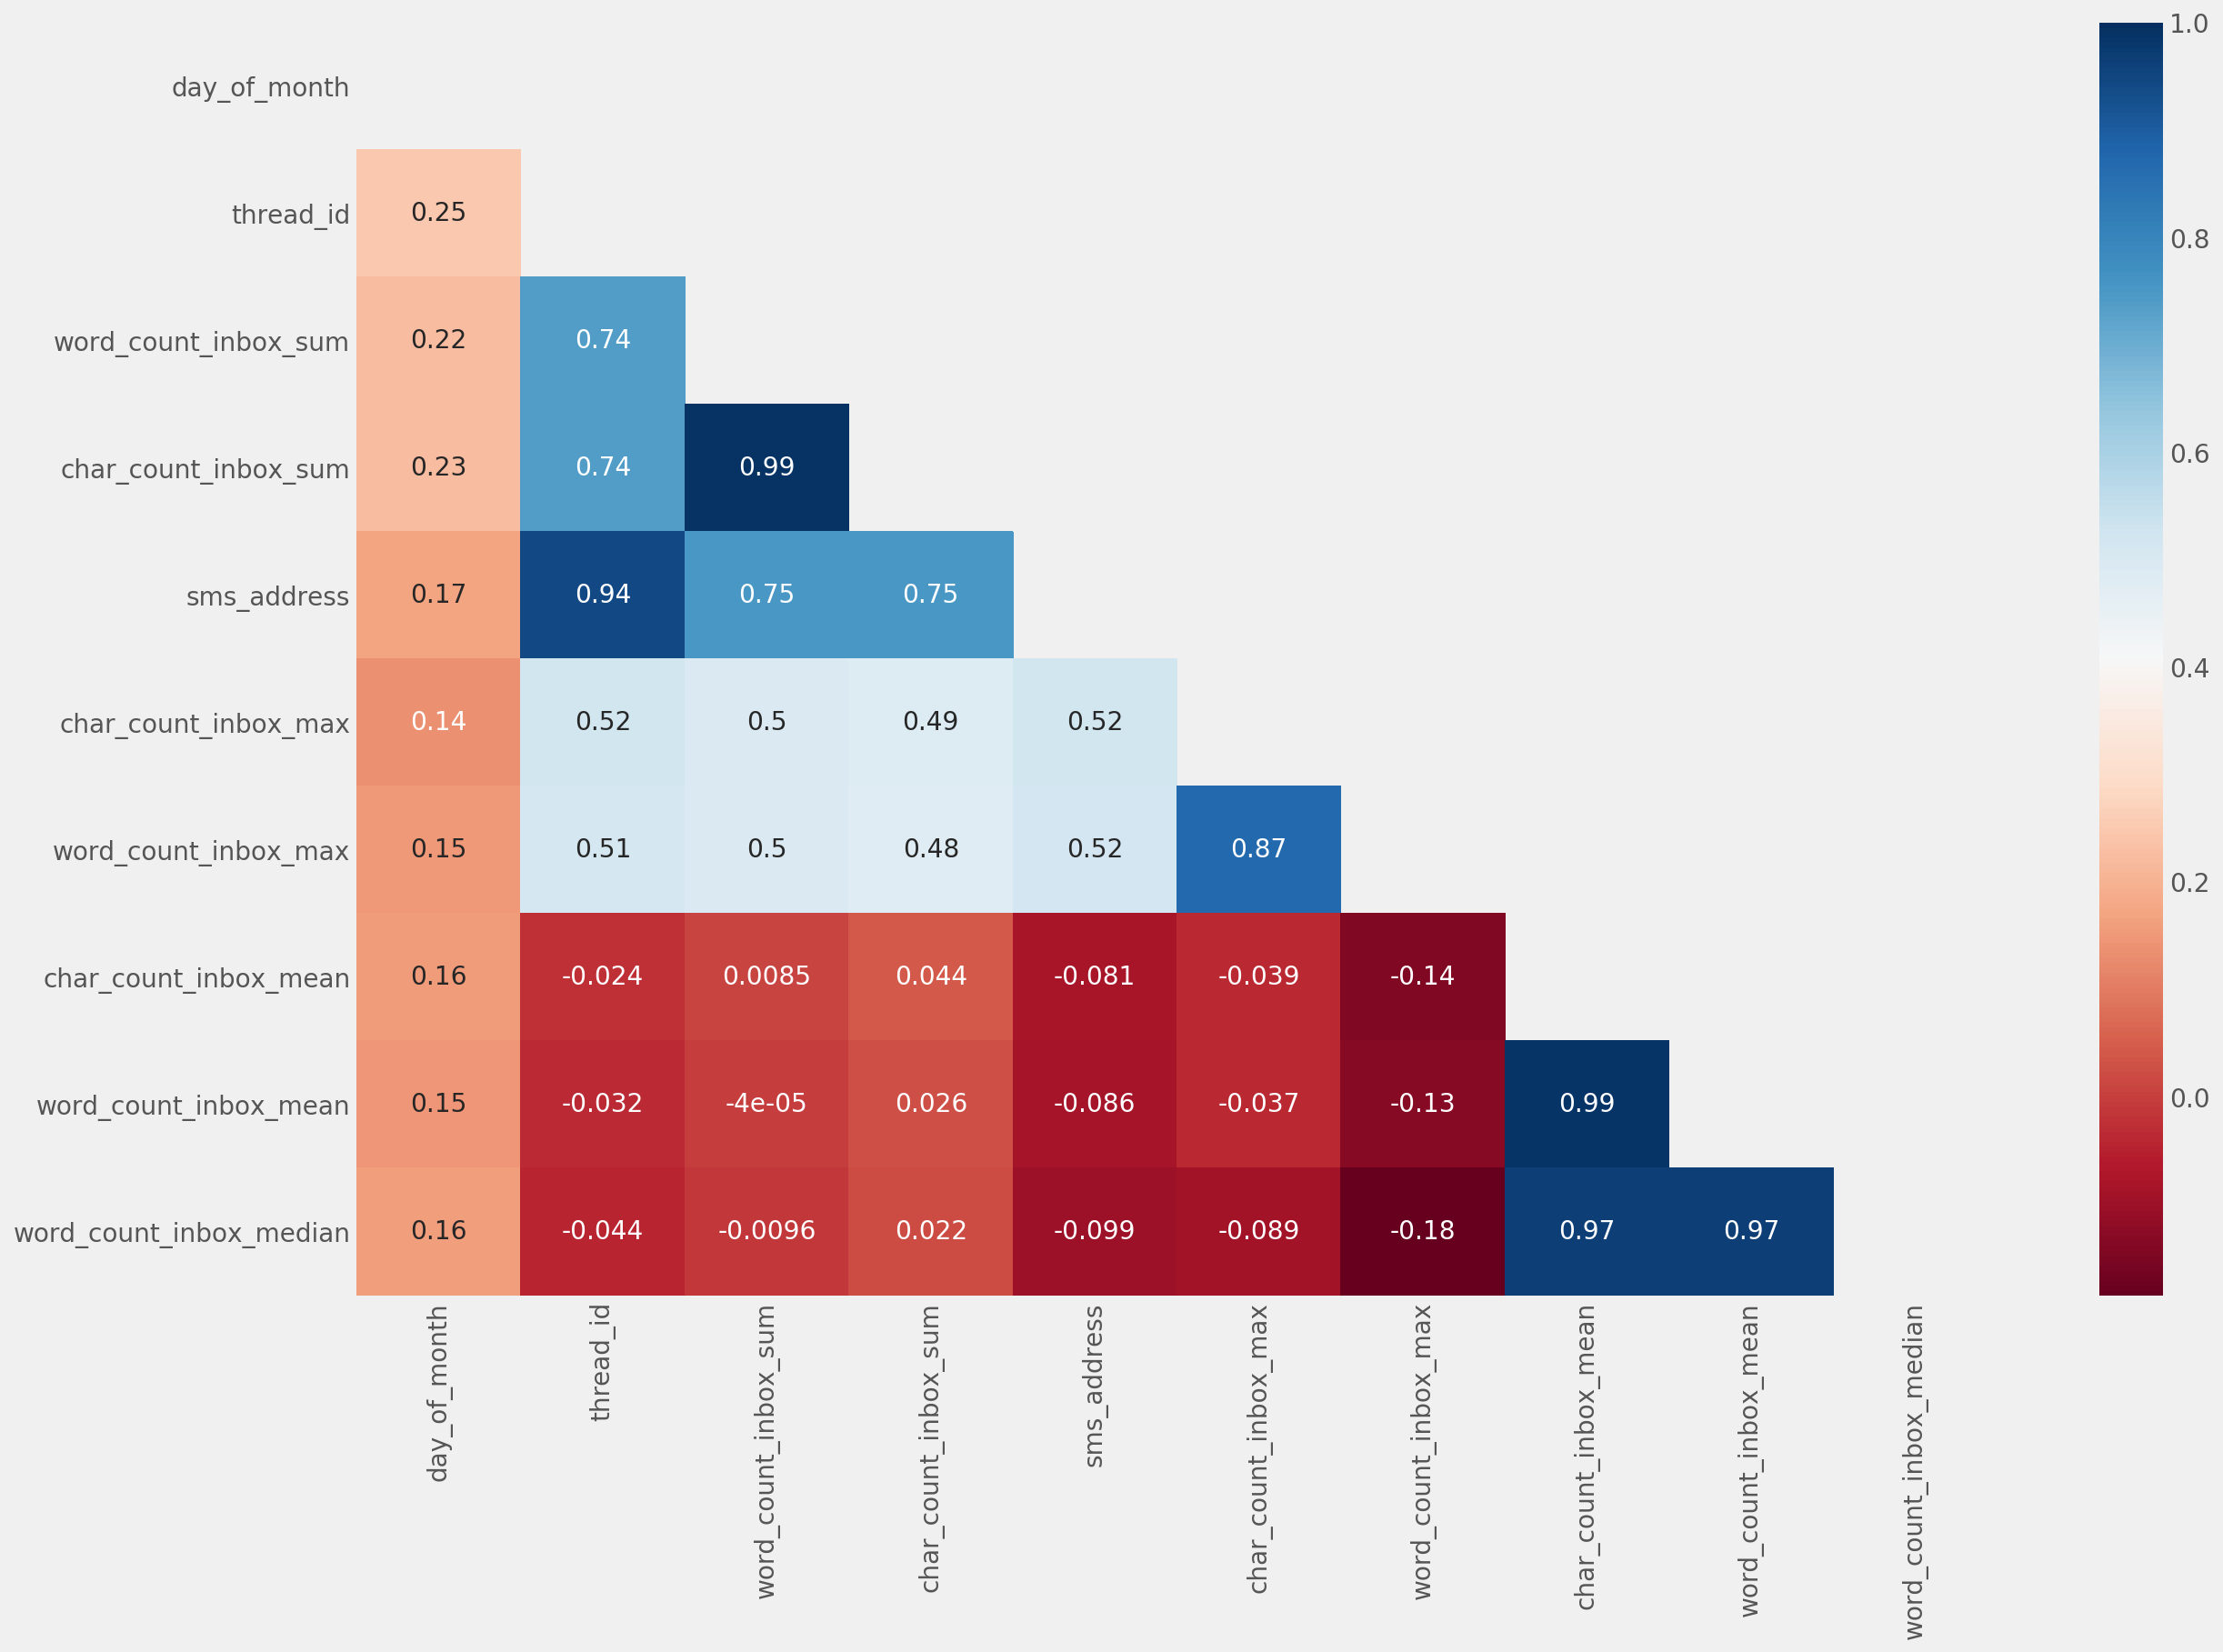

In [58]:
def ordered_heat_map(df, target, k=10):
    corrs = df.corr()
    
    # set figure size
    fig, ax = plt.subplots(figsize = (18, 12))
    
    cols = corrs.nsmallest(k, target)[target].index # can use nsmallest instead of nlargest too
    cm = np.corrcoef(df[cols].values.T)
    
    #generate a mask for the upper triangle
    mask = np.zeros_like(cm, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    #plot heatmap
    ax = sns.heatmap(cm, mask=mask, annot=True, yticklabels=cols.values, xticklabels=cols.values, cmap="RdBu")
    
    plt.show()
ordered_heat_map(baseline_df, target="defaulted", k=10)

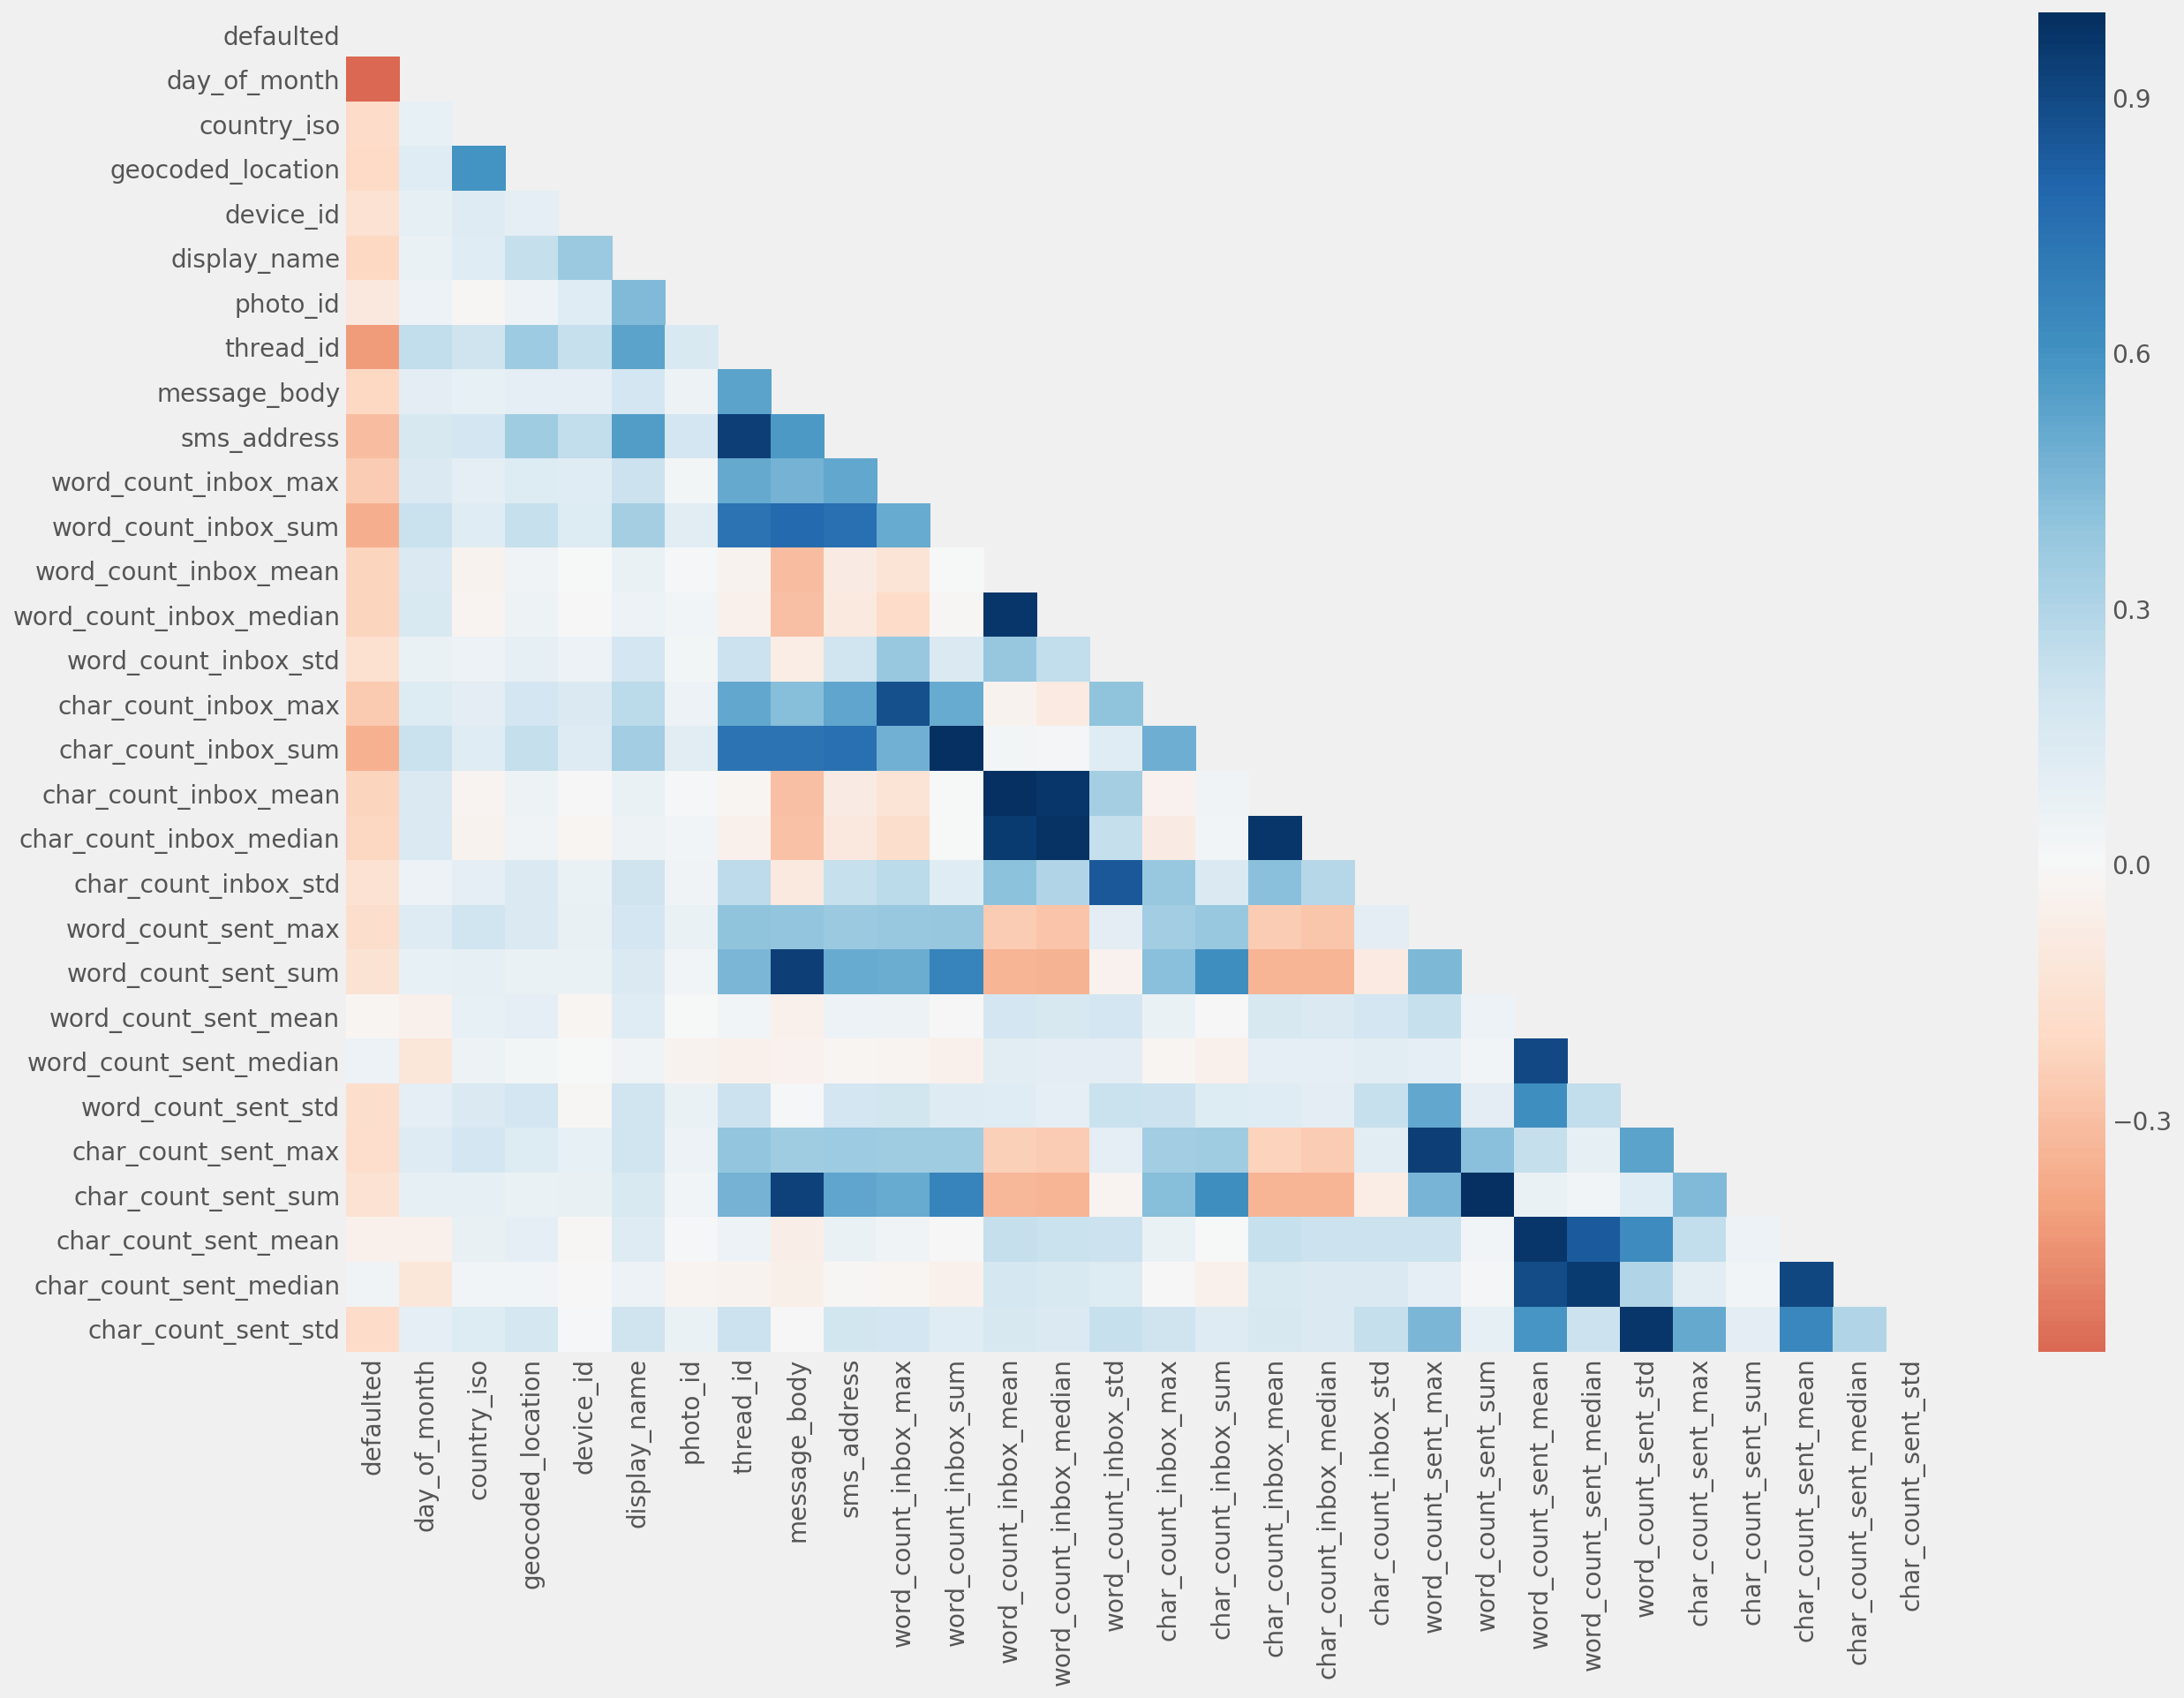

In [60]:
def correlation_heat_map(df):
    corrs = df.corr()

    # set figure size
    fig, ax = plt.subplots(figsize = (18, 13))

    #generate a mask for the upper triangle
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    #plot heatmap
    ax = sns.heatmap(corrs, mask=mask, cmap="RdBu", center=0.0)

    #resize labels
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=90)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    plt.show()
correlation_heat_map(baseline_df)

# Throwing Models Around

In [61]:
# if the defaulted column is 1 then they defaulted, 0 if they repaid
target = 'defaulted'
variables = baseline_df.columns[baseline_df.columns != target]

x = baseline_df[variables]
y = baseline_df[target]

train_x, test_x, train_y, test_y = model_selection.train_test_split(x, y, test_size=0.33, random_state=42)

In [62]:
dt_gini = tree.DecisionTreeClassifier(max_depth=10)
dt_gini = dt_gini.fit(train_x,train_y)
y_pred = dt_gini.predict(test_x)
acc_gini = accuracy_score(test_y,y_pred)
print("Decision Tree (Gini) Accuracy = %3.2f" %(acc_gini))

Decision Tree (Gini) Accuracy = 0.75


In [69]:
dt_entropy = tree.DecisionTreeClassifier('entropy',max_depth=10)
dt_entropy = dt_entropy.fit(train_x,train_y)
y_pred = dt_entropy.predict(test_x)
acc_entropy = accuracy_score(test_y,y_pred)
print("Decision Tree (Entropy) Accuracy = %3.2f" %(acc_entropy))

Decision Tree (Entropy) Accuracy = 0.78


In [68]:
lr = linear_model.LogisticRegression()
lr = lr.fit(train_x,train_y)
y_pred = lr.predict(test_x)
acc_lr = accuracy_score(test_y, y_pred)
print("Logistic Regression Accuracy = %3.2f" %(acc_lr))

Logistic Regression Accuracy = 0.76


In [29]:
from scipy import stats

30

In [70]:
params = np.append(lr.intercept_, lr.coef_)
predictions = lr.predict(test_x)

newX = pd.DataFrame({"Constant":np.ones(len(test_x))}).join(pd.DataFrame(test_x.reset_index(drop=True)))
MSE = (sum((test_y-predictions)**2))/(len(newX)-len(newX.columns))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params / sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilites"] = [params,sd_b,ts_b,p_values]
print(myDF3)

    Coefficients  Standard Errors  t values  Probabilites
0         0.0014            0.521     0.003         0.998
1         0.0023            0.015     0.153         0.879
2        -0.0021            0.091    -0.023         0.982
3        -0.0037            0.036    -0.102         0.919
4         0.0006            0.086     0.008         0.994
5        -0.0010            0.000    -4.084         0.000
6        -0.0039            0.002    -2.409         0.017
7        -0.0234            0.001   -18.266         0.000
8        -0.0001            0.000    -0.539         0.591
9         0.0191            0.001    18.363         0.000
10       -0.0091            0.003    -2.743         0.007
11       -0.0004            0.000   -12.588         0.000
12        0.0043            0.113     0.038         0.970
13       -0.0011            0.064    -0.017         0.987
14        0.0077            0.099     0.077         0.938
15        0.0002            0.001     0.243         0.809
16        0.00

In [74]:
myDF3['variables'] = baseline_df.columns
myDF3 = myDF3.set_index('variables')
myDF3 = myDF3.rename(index={'defaulted':'intercept'})

In [75]:
myDF3

,Coefficients,Standard Errors,t values,Probabilites
variables,,,,
intercept,0.0014,0.521,0.003,0.998
day_of_month,0.0023,0.015,0.153,0.879
country_iso,-0.0021,0.091,-0.023,0.982
geocoded_location,-0.0037,0.036,-0.102,0.919
device_id,0.0006,0.086,0.008,0.994
display_name,-0.0010,0.000,-4.084,0.000
photo_id,-0.0039,0.002,-2.409,0.017
thread_id,-0.0234,0.001,-18.266,0.000
message_body,-0.0001,0.000,-0.539,0.591


In [134]:
print(classification_report(y_true=test_y, y_pred=y_pred))

             precision    recall  f1-score   support

          0       0.76      0.77      0.77        66
          1       0.77      0.76      0.76        66

avg / total       0.77      0.77      0.77       132



In [141]:
test_y.reset_index()

,user_id,defaulted
0,user-210,0
1,user-281,1
2,user-34,1
3,user-211,0
4,user-94,1
5,user-85,1
6,user-330,0
7,user-95,1
8,user-267,0
9,user-127,0


In [145]:
logit_errors_df = pd.concat([test_y.reset_index(), pd.Series(y_pred.reshape(132))], axis=1).rename(columns={0: "prediction"})

In [150]:
logit_errors_df[(logit_errors_df.defaulted != logit_errors_df.prediction) & (logit_errors_df.defaulted == 1)]

,user_id,defaulted,prediction
26,user-115,1,0
27,user-226,1,0
28,user-263,1,0
35,user-117,1,0
41,user-56,1,0
46,user-149,1,0
50,user-47,1,0
54,user-375,1,0
59,user-153,1,0
66,user-353,1,0


In [153]:
baseline_df[baseline_df.index == "user-56"]

,defaulted,day_of_month,weekday,country_iso,geocoded_location,device_id,display_name,photo_id,thread_id,message_body,sms_address,word_count_inbox_min,word_count_inbox_max,word_count_inbox_sum,word_count_inbox_mean,word_count_inbox_median,word_count_inbox_std,char_count_inbox_min,char_count_inbox_max,char_count_inbox_sum,char_count_inbox_mean,char_count_inbox_median,char_count_inbox_std,word_count_min,word_count_max,word_count_sum,word_count_mean,word_count_median,word_count_std,char_count_min,char_count_max,char_count_sum,char_count_mean,char_count_median,char_count_std
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
user-56,1,28,6,0,0,2,85,0,155,3881,127,1,63,19041,5.94103,4.0,6.674524,0,309,105196,32.822465,20.0,39.071999,1.0,62.0,12850.0,4.497725,3.0,4.643157,0.0,302.0,65911.0,23.070004,16.0,24.570128


In [89]:
from sklearn.metrics import confusion_matrix
import itertools

In [90]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.77272727 0.22727273]
 [0.24242424 0.75757576]]


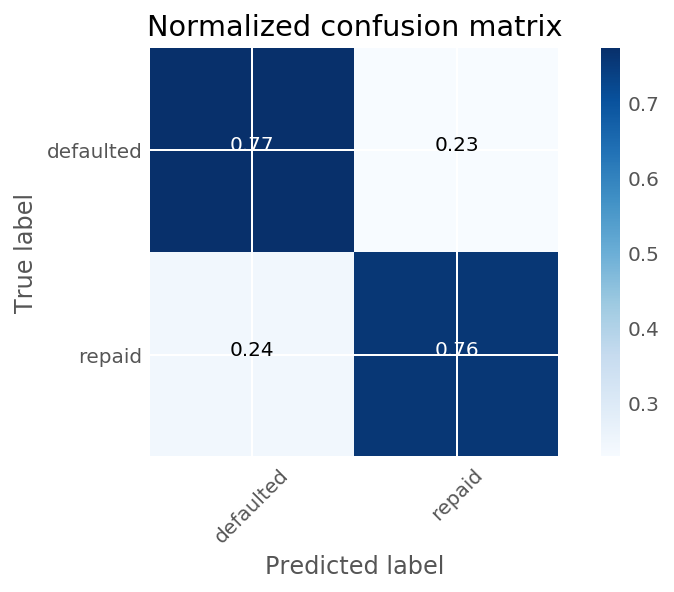

In [91]:
class_names = ['defaulted', 'repaid']

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, 
                      classes=class_names, 
                      normalize=True,
                      title='Normalized confusion matrix')

plt.show()

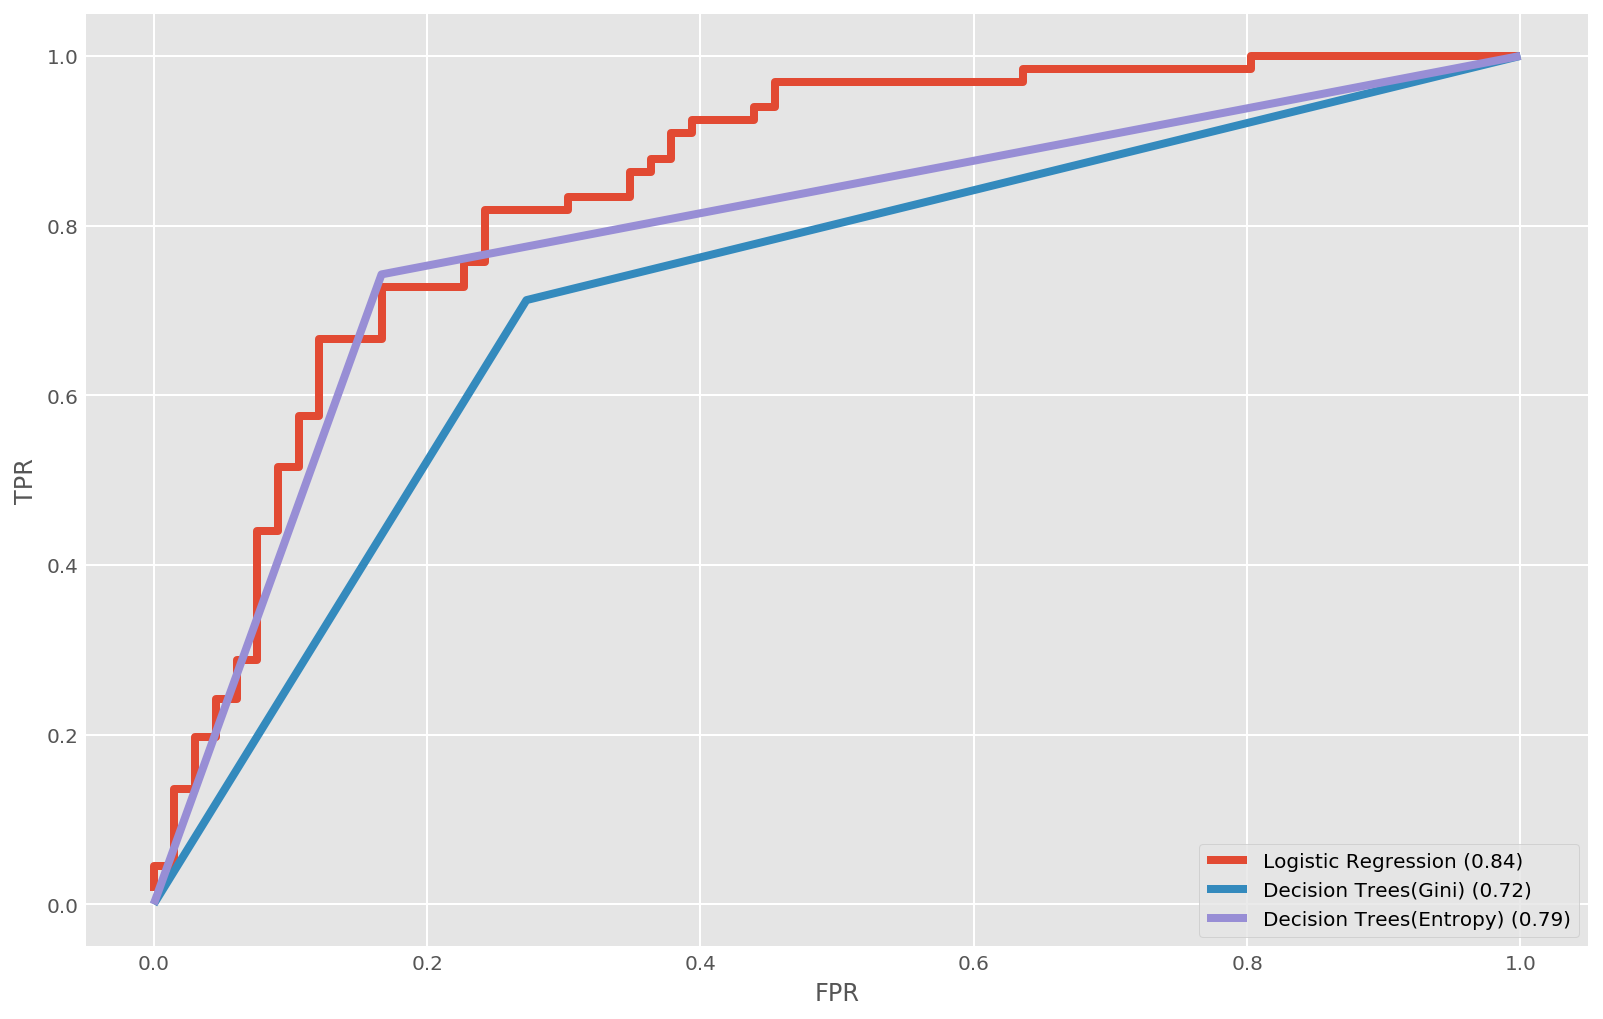

In [92]:
dt_gini_prob = dt_gini.predict_proba(test_x)
dt_entropy_prob = dt_entropy.predict_proba(test_x)
lr_prob = lr.predict_proba(test_x)

fpr_gini, tpr_gini, thresholds_gini = roc_curve(y_true=test_y, y_score = dt_gini_prob[:,1], pos_label=1)
fpr_entropy, tpr_entropy, thresholds_entropy = roc_curve(y_true=test_y, y_score = dt_entropy_prob[:,1], pos_label=1)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_true=test_y, y_score = lr_prob[:,1], pos_label=1)

roc_auc_gini = roc_auc_score(y_true=test_y, y_score = dt_gini_prob[:,1])
roc_auc_entropy = roc_auc_score(y_true=test_y, y_score = dt_entropy_prob[:,1])
roc_auc_lr = roc_auc_score(y_true=test_y, y_score = lr_prob[:,1])

plt.figure(1, figsize=(12, 8));

plt.xlabel('FPR');
plt.ylabel('TPR');
plt.plot(fpr_lr,tpr_lr,label='Logistic Regression (%3.2f)'%roc_auc_lr)
plt.plot(fpr_gini,tpr_gini,label='Decision Trees(Gini) (%3.2f)'%roc_auc_gini)
plt.plot(fpr_entropy,tpr_entropy,label='Decision Trees(Entropy) (%3.2f)'%roc_auc_entropy)
plt.yticks(np.arange(0.0,1.01,.2))
plt.legend(loc='lower right')
plt.show();

In [106]:
import statsmodels.api as sm

/Users/Mitchell/anaconda/envs/ml/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [108]:
logit = sm.Logit(train_y, train_x)

# fit the model
result = logit.fit()

Optimization terminated successfully.
         Current function value: inf
         Iterations 12


/Users/Mitchell/anaconda/envs/ml/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1214: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/Mitchell/anaconda/envs/ml/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1264: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


In [111]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary())

AttributeError: module 'scipy.stats' has no attribute 'chisqprob'

In [93]:
# Set the random seed to be able to repeat the experiment
random_seed = 42 

In [94]:
models = {'Decision Tree':DecisionTreeClassifier(),
          'Bagging':BaggingClassifier(DecisionTreeClassifier()),
          'Random Forest':RandomForestClassifier(),
          'Ada Boost':AdaBoostClassifier(DecisionTreeClassifier())}

In [95]:
folds = StratifiedKFold(n_splits=10,shuffle=True,random_state=random_seed)
scores = {}
for model_name in models:
    clf = models[model_name];
    score = cross_val_score(clf,x,y,cv=folds)
    scores[model_name]=(np.average(score),np.std(score))
    print('\t%26s\t%.3f +/- %.3f'%(model_name,scores[model_name][0],scores[model_name][1]))

	             Decision Tree	0.760 +/- 0.067
	                   Bagging	0.800 +/- 0.068
	             Random Forest	0.790 +/- 0.071
	                 Ada Boost	0.740 +/- 0.085


In [96]:
k = 10
knn_models = {'k-Nearest Neighbors':KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree'),
          'Bagging':BaggingClassifier(KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree'))}

In [97]:
folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=random_seed)

scores = {}

for model_name in knn_models:
    clf = clone(knn_models[model_name]);
    score = cross_val_score(clf,x,y,cv=folds)
    scores[model_name]=(np.average(score),np.std(score))
    print('\t%26s\t%.3f +/- %.3f'%(model_name,scores[model_name][0],scores[model_name][1]))

	       k-Nearest Neighbors	0.660 +/- 0.057
	                   Bagging	0.670 +/- 0.037


In [98]:
estimators = [
        ('k-Nearest Neighbors', KNeighborsClassifier(n_neighbors=16, algorithm='kd_tree')), 
        ('Decision Tree', DecisionTreeClassifier(max_depth=None)), 
        ('Logistic Regression', LogisticRegression(random_state=random_seed)),
        ('Bagging', BaggingClassifier(DecisionTreeClassifier(max_depth=3))),
        ('Random Forest',RandomForestClassifier()),
        ('Ada Boost',AdaBoostClassifier(DecisionTreeClassifier(max_depth=3)))
    ]

In [99]:
for (label,model) in estimators:
    scores = cross_val_score(clone(model), x, y, cv=folds, scoring='accuracy')
    print('\t%26s\t%.3f +/- %.3f'%(label,np.average(scores),np.std(scores)))

	       k-Nearest Neighbors	0.682 +/- 0.042
	             Decision Tree	0.745 +/- 0.051
	       Logistic Regression	0.750 +/- 0.040
	                   Bagging	0.812 +/- 0.043
	             Random Forest	0.792 +/- 0.051
	                 Ada Boost	0.795 +/- 0.044


In [100]:
voting = VotingClassifier(estimators=estimators)
scores = cross_val_score(voting, x, y, cv=folds, scoring='accuracy')
print('\t%26s\t%.3f +/- %.3f'%('Voting',np.average(scores),np.std(scores)))

/Users/Mitchell/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Mitchell/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Mitchell/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Mitchell/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning

	                    Voting	0.818 +/- 0.047


/Users/Mitchell/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [101]:
fitted = {}
for model_name in models:
    model = clone(models[model_name])
    score = model.fit(x,y)
    if(model_name != 'Bagging'):
        fitted[model_name] = (model,score,model.feature_importances_)

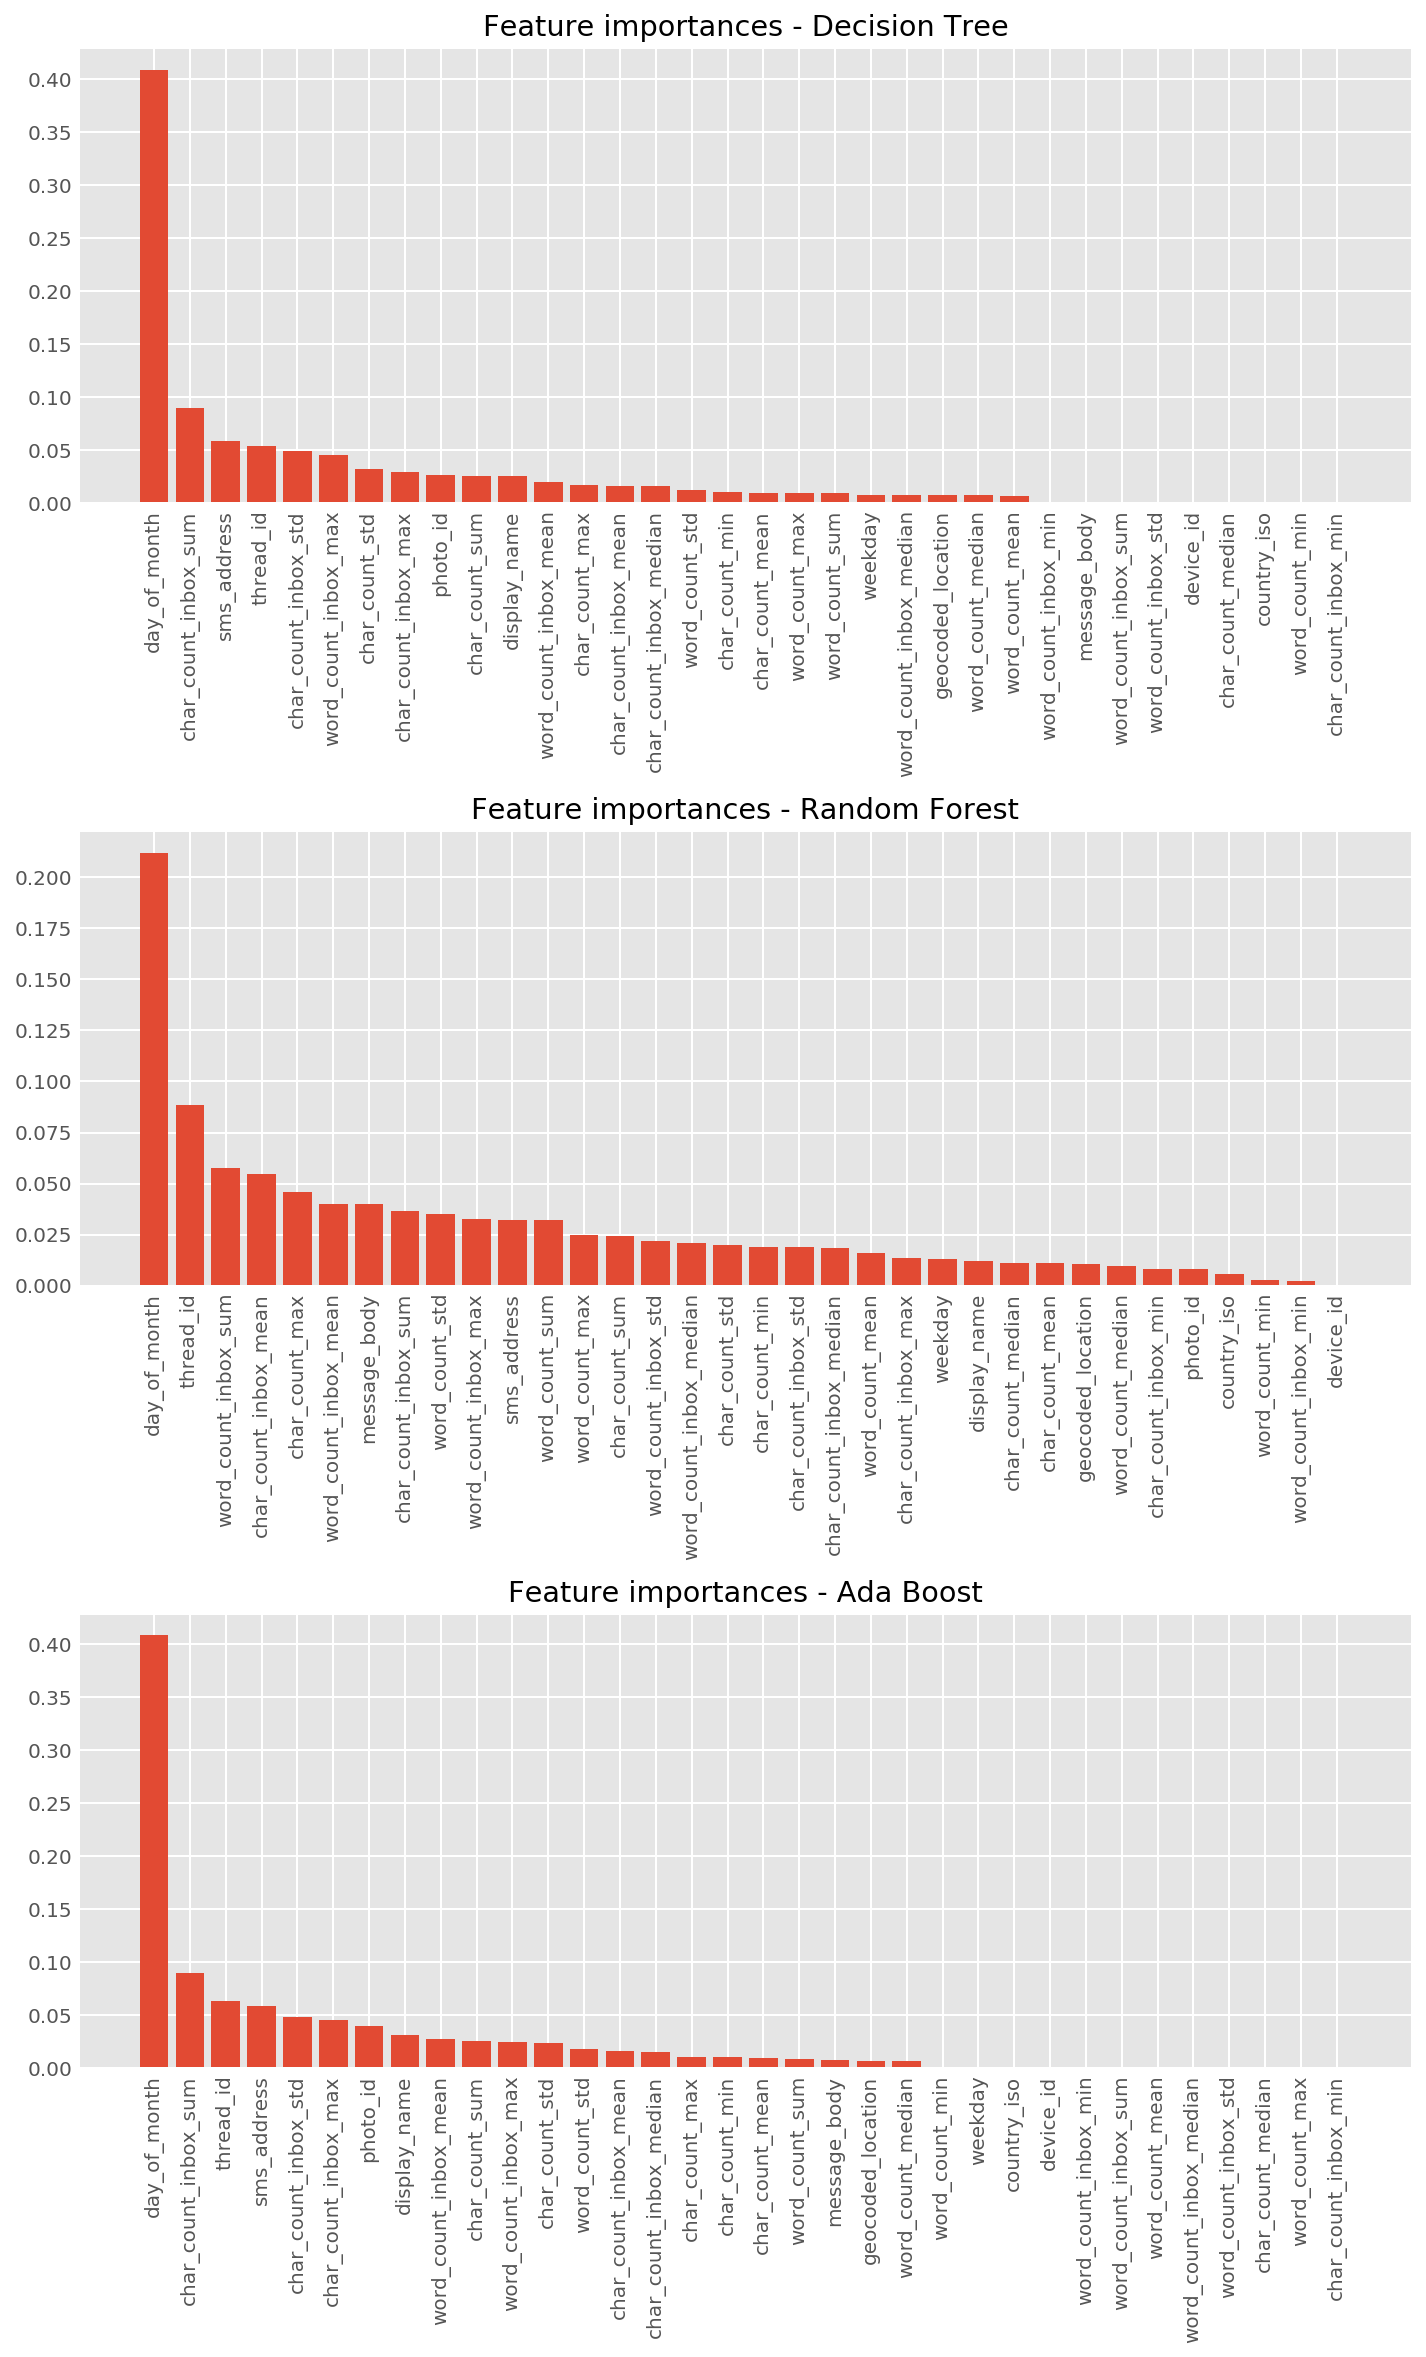

In [102]:
plot_idx = 1
plt.figure(figsize=(10,20))
for model_name in fitted:
    plt.subplot(4,1,plot_idx)
    importances = fitted[model_name][2]
    indices = np.argsort(importances)[::-1]

    # Plot the feature importances 
    plt.title("Feature importances - "+model_name)
    plt.xticks(range(x.shape[1]),x.columns[indices],rotation='vertical')
    
    plt.bar(range(x.shape[1]), importances[indices],align="center")
    plot_idx = plot_idx + 1

plt.tight_layout(pad=1.08, h_pad=None, w_pad=None)
plt.show()

# Gridsearch through Hyperspace

In [26]:
target = 'defaulted'
variables = baseline_df.columns[baseline_df.columns!=target]

X, y = baseline_df[variables], baseline_df[target]

In [27]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [28]:
param_dist_r = {"max_depth": [3, None],
              "max_features": randint(1, 8),
              "min_samples_split": randint(2, 11),
              "min_samples_leaf": randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

param_grid_g = {"max_depth": [3, None],
              "max_features": [1, 3, 8],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

In [29]:
# Build a classifier
clf = RandomForestClassifier(n_estimators=20)

# Run Randomized Search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist_r,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 3.40 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.825 (std: 0.039)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}

Model with rank: 2
Mean validation score: 0.823 (std: 0.032)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'min_samples_leaf': 8, 'min_samples_split': 10}

Model with rank: 3
Mean validation score: 0.820 (std: 0.033)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 7}



In [30]:
# Run Grid Search
grid_search = GridSearchCV(clf, param_grid=param_grid_g)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

GridSearchCV took 29.90 seconds for 216 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.835 (std: 0.038)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 10, 'min_samples_split': 2}

Model with rank: 2
Mean validation score: 0.830 (std: 0.047)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10}

Model with rank: 3
Mean validation score: 0.825 (std: 0.045)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'max_features': 8, 'min_samples_leaf': 10, 'min_samples_split': 2}

